# Custom Corolectal Cancer Pre-trained Model

### This notebook contains the implementation for the first pre-trained CNN encoder outlined as the first task of the project proposal. The architecture selected is ResNet and the implementation used comes from the `torchvision` module.

### Below are 4 different attempts at pre-training the model to find the ideal loop, optimizer and loss function that will yield the best performance for the model. The following 4 optimizers were selected.
- #### **SGD**
- #### **SGD + Momentum**
- #### **RMSProp**
- #### **Adam**

### Each loop utilizes the Categorical cross Entropy (CCE) loss function due to the presence of 3 distinct classes in the dataset (MUS, NORM, STR)

#### Initializations

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tempfile
import ray.cloudpickle as pickle
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from sklearn.manifold import TSNE
from PIL import Image
from functools import partial
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from enum import Enum

class optimizer_choice(Enum):
    SGD = 0
    MOMENTUM = 1
    RMSPROP = 2
    ADAM = 3

print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")

torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# [Task 1]: Import and initialize ResNet50
resnet_corolectal_cancer_model = resnet50(weights=None)
'''
Note that by default the ResNet implementations from PyTorch's source code follow the ImaegNet fully connected layer specification of 2048x1000.
    Therefore, for our project, we need to change it to use 3 classes according to the first dataset (MUS, NORM, STR).
    See the source code for the base class here (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).
    Stack Overflow post here (https://stackoverflow.com/questions/68980724/the-number-of-classes-in-pytorch-pretrained-model).

    Additionally, we will need to remove the last layer to be able to pass the features to a different learning algorithm in task 2.
    Here is a Stack Overflow post about it (https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch).

'''
resnet_corolectal_cancer_model.fc = nn.Linear(2048, 3)
resnet_corolectal_cancer_model.to(device=device)
resnet_corolectal_cancer_model.train()

# [Task 1]: Import and initialize the optimizer algorithms
'''
Hyperparameters for vanilla SGD recommended settings: learning rate = 0.001
                                                      L2 regularizer penalty = 1e-6
                                                      Batch Size = 100
'''
learning_rate = 0.001
l2_regularizer = 1e-6
batch_size = 32
num_epochs = 5 

sgd_no_momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

'''
Hyperparameters for SGD + momentum recommended settings: learning rate = 0.001
                                                         L2 regularizer penalty = 1e-6
                                                         Batch Size = 100
                                                         Momentum = 0.9
                                                         Nesterov = true
'''
sgd_momentum = 0.9
sgd_momentum_use_nesterov = True

sgd_momentum = optim.SGD(resnet_corolectal_cancer_model.parameters(),
                            lr=learning_rate,
                            weight_decay=l2_regularizer,
                            momentum=sgd_momentum,
                            nesterov=sgd_momentum_use_nesterov)

'''
Hyperparameters for Adam recommended settings: learning rate = 0.001
                                               L2 regularizer penalty = 1e-6
                                               Batch Size = 100
                                               Beta 1 (Momentum) = 0.9
                                               Beta 2 (RMS decay rate) = 0.999
                                               Division stablizer = 1e-8
'''
adam_betas = (0.9, 0.999)
epsilon_division_stablizer = 1e-8

adam = optim.Adam(resnet_corolectal_cancer_model.parameters(),
                    lr=learning_rate,
                    weight_decay=l2_regularizer,
                    betas=adam_betas,
                    eps=epsilon_division_stablizer)

'''
Hyperparameters for RSMProp recommended settings: learning rate = 0.001
                                                  L2 regularizer penalty = 1e-6
                                                  Batch Size = 100
                                                  Decay rate = 0.999
                                                  Division stablizer = 1e-8
'''
rmsprop_decay_rate = adam_betas[1]

rmsprop = optim.RMSprop(resnet_corolectal_cancer_model.parameters(),
                        lr=learning_rate,
                        weight_decay=l2_regularizer,
                        alpha=rmsprop_decay_rate,
                        eps=epsilon_division_stablizer)

# [Task 1]: Import and initialize the t-SNE visualization algorithm
tsne = TSNE(random_state=42)

torch.cuda.is_available(): True


In [9]:
def plot_model_result(_losses, _accuracies, _num_batches, _is_training=True, _optimizer_name="SGD", _dataset_name="Corolectal Cancer"):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(np.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(np.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{'Training' if _is_training else 'Test'} Epoch vs. Loss for {_dataset_name} Set ({_optimizer_name})")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(np.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Minibatch size = {_num_batches}, Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(np.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(np.arange(0, 110, 10))
    momentum_acc_ax.set_title(f"{'Training' if _is_training else 'Test'} Epoch vs. Accuracy for {_dataset_name} Set ({_optimizer_name})")
    momentum_acc_ax.grid()

    plt.show()


def do_model_epoch_loop(_model, _data_loader, _num_epochs, _optimizer, _is_training=True, _device="cpu", _show_plot=True, _optimizer_name="SGD", _dataset_name="Corolectal_Cancer"):
    epoch_losses = []

    epoch_accuracies = []

    if _is_training:
        _model.train()
    else:
        _model.eval()

    num_batches = len(_data_loader)

    for epoch in range(_num_epochs):  
        total_epoch_loss = 0.0  # Track loss for the epoch
        
        total_epoch_acc = 0.0  # Track accuracy for the epoch

        for inputs, labels in _data_loader:
            inputs, labels = inputs.to(_device), labels.to(_device) 

            _optimizer.zero_grad() 
            
            outputs = _model(inputs)  # Forward pass
            loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
            if _is_training:
                loss.backward()  # Backward pass to compute gradients
            
                _optimizer.step()  # Update model parameters using gradients

            total_epoch_loss += loss.item()

            softmax_confidence_scores = F.softmax(outputs, dim=1)
            label_prediction = torch.argmax(softmax_confidence_scores, dim=1).view(-1)
            total_epoch_acc += ((label_prediction == labels).sum().item() / len(labels)) * 100

        epoch_losses.append(total_epoch_loss / num_batches)

        epoch_accuracies.append(total_epoch_acc / num_batches)

        print(f"[INFO] Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_losses[epoch]:.4f}, Accuracy: {epoch_accuracies[epoch]:.4f}%")

    if _show_plot:
        plot_model_result(epoch_losses, epoch_accuracies, num_batches, _is_training, _dataset_name)

    if not _is_training:
        state_dict = _model.state_dict()
        torch.save(state_dict, f"Models/ResNet_{_optimizer_name}_{_dataset_name}_pre_trained.tar")

        print("[INFO] Saved the pre-trained model!")


def load_data(_data_dir="Datasets/Corolectal Cancer/"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
    ])

    if not os.path.exists(_data_dir):
        raise FileNotFoundError(f"Dataset directory '{_data_dir}' does not exist.")

    full_dataset = datasets.ImageFolder(root=_data_dir, transform=transform)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    return train_dataset, test_dataset


def tune_model(_config, _data_dir="Datasets/Corolectal Cancer/", _optimizer_choice=optimizer_choice.SGD.value):
    resnet = resnet50(weights=None)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            resnet = nn.DataParallel(resnet)
    resnet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = None
    if _optimizer_choice == optimizer_choice.SGD.value:
        optimizer = optim.SGD(resnet.parameters(), lr=_config["lr"], weight_decay=_config["l2"])
    elif _optimizer_choice == optimizer_choice.MOMENTUM.value:
        optimizer = optim.SGD(resnet.parameters(), lr=_config["lr"], weight_decay=_config["l2"], momentum=_config["momentum"], nesterov=_config["nesterov"])
    elif _optimizer_choice == optimizer_choice.RMSPROP.value:
        optimizer = optim.RMSprop(resnet.parameters(), lr=_config["lr"], weight_decay=_config["l2"], alpha=_config["betas"][1], eps=_config["eps"])
    else:
        optimizer = optim.Adam(resnet.parameters(), lr=_config["lr"], weight_decay=_config["l2"], betas=_config["betas"], eps=_config["eps"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            resnet.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = load_data(_data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=int(_config["batch_size"]), shuffle=True, num_workers=8)
    valloader = torch.utils.data.DataLoader(val_subset, batch_size=int(_config["batch_size"]), shuffle=True, num_workers=8)

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0

        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # print statistics
            running_loss += loss.item()

            epoch_steps += 1

            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))

                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        
        val_steps = 0

        total = 0

        correct = 0

        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnet(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()

                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": resnet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({"loss": val_loss / val_steps, "accuracy": correct / total}, checkpoint=checkpoint,)

    print("Finished Training")

def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0

    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    return correct / total

def start_model_tuning(_num_samples=10, _max_num_epochs=10, _gpus_per_trial=2, _optimizer=optimizer_choice.SGD.value, _dir="Datasets/Corolectal Cancer"):
    data_dir = os.path.abspath(_dir)
    load_data(data_dir)

    config = {
        "batch_size": tune.choice([2 ** i for i in range(1, 9)]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "l2": tune.choice([2**i for i in range(9)]),
        "momentum": tune.choice([0.9, 0.8, 0.7, 0.6]),
        "betas": tune.choice([(0.9, 0.999), (0.8, 0.888), (0.7, 0.777)]),
        "eps": tune.loguniform(1e-8, 1e-6),
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=_max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        partial(tune_model, _data_dir=data_dir, _optimizer_choice=_optimizer),
        resources_per_trial={"cpu": 2, "gpu": _gpus_per_trial},
        config=config,
        num_samples=_num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")

    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = resnet50()
    device = "cpu"

    if torch.cuda.is_available():
        device = "cuda:0"

        if _gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)

    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

#### Data Preprocessing

In [2]:
'''
Source(s):
    - Key Steps in Data Preprocessing: https://www.techtarget.com/searchdatamanagement/definition/data-preprocessing 
'''
# Optimizers
optimizer = optim.RMSprop(resnet_corolectal_cancer_model.parameters(), lr=learning_rate, weight_decay=l2_regularizer)

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet Normalization
])

dataset_root = 'Datasets/Corolectal Cancer/'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' does not exist.")


full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

# Data Profiling: Check number of classes and their album size
if len(full_dataset) == 0:
    raise ValueError("The dataset is empty. Please check the image files.")

num_classes = len(full_dataset.classes)
if num_classes == 0:
    raise ValueError("Classes Detected: FAILED")
else:
    print(f"[INFO] Classes Detected: {num_classes}, CHECK")

# Display full dataset size
class_counts = np.bincount(full_dataset.targets)
for i, count in enumerate(class_counts):
    print(f"\t> {full_dataset.classes[i]}: {count} samples")

# Data Cleansing: Conditions to meet otherwise discarded warning
min_samples = 5  
classes_to_remove = [full_dataset.classes[i] for i, count in enumerate(class_counts) if count < min_samples]
if classes_to_remove:
    print(f"[WARNING] Classes to remove due to low sample size: {classes_to_remove}")

# Data Validation: Split 80:20, DataLoaders for train/test
train_size = int(0.8 * len(full_dataset))  
test_size = len(full_dataset) - train_size  
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def check_dataloader(dataloader, name):
    try:
        inputs, labels = next(iter(dataloader))
        print(f"[INFO] {name} DataLoader is working: CHECK\n\t> Inputs size: {inputs.size()}, \n\t> Labels size: {labels.size()}")
    except Exception as e:
        raise RuntimeError(f"[ERROR] {name} DataLoader failed: {e}")

check_dataloader(train_dataloader, "Train")
check_dataloader(test_dataloader, "Test")

[INFO] Classes Detected: 3, CHECK
	> MUS: 2000 samples
	> NORM: 2000 samples
	> STR: 2000 samples
[INFO] Train DataLoader is working: CHECK
	> Inputs size: torch.Size([32, 3, 224, 224]), 
	> Labels size: torch.Size([32])
[INFO] Test DataLoader is working: CHECK
	> Inputs size: torch.Size([32, 3, 224, 224]), 
	> Labels size: torch.Size([32])


#### SGD + Momentum Optimizations

[INFO] Starting training w/SGD + Momentum... CHECK
[INFO] Epoch 1/5, Loss: 0.9354, Accuracy: 51.1042%
[INFO] Epoch 2/5, Loss: 0.6491, Accuracy: 69.8958%
[INFO] Epoch 3/5, Loss: 0.4774, Accuracy: 80.3958%
[INFO] Epoch 4/5, Loss: 0.4357, Accuracy: 82.4792%
[INFO] Epoch 5/5, Loss: 0.3910, Accuracy: 84.6042%


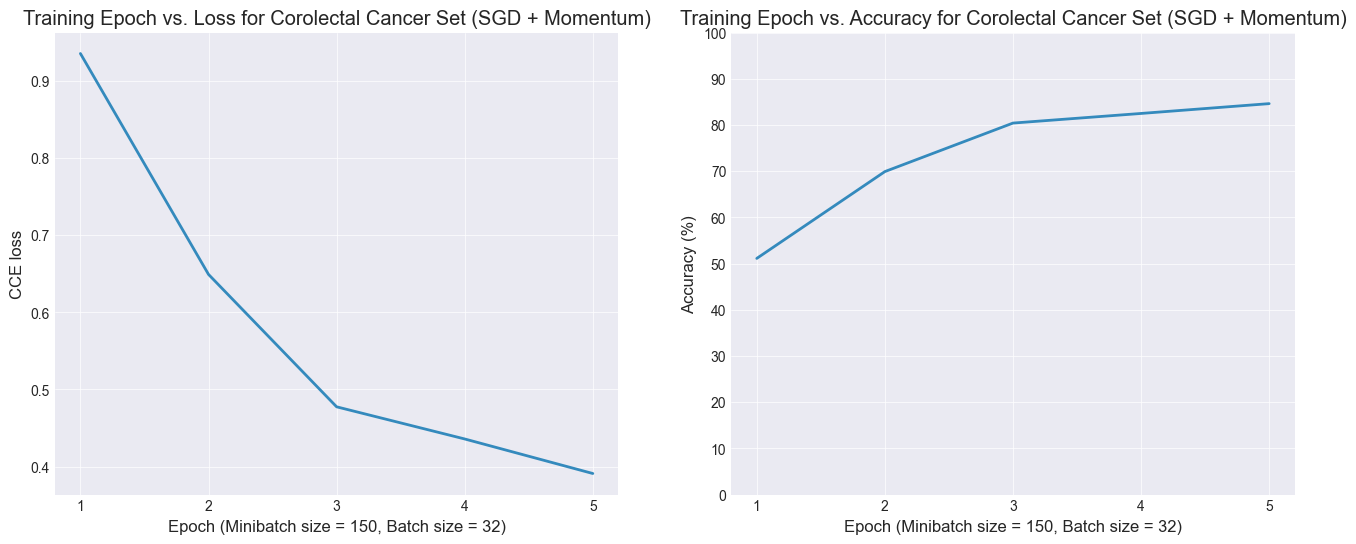

In [38]:
# Training loop
print("[INFO] Starting training w/SGD + Momentum... CHECK")

do_model_epoch_loop(resnet_corolectal_cancer_model, train_dataloader, num_epochs, sgd_momentum, _device=device)

print("[INFO] Finished training w/SGD + Momentum!")

[INFO] Begin inference on test set...
[INFO] Epoch 1/5, Loss: 0.3100, Accuracy: 87.7467%
[INFO] Epoch 2/5, Loss: 0.3104, Accuracy: 88.0757%
[INFO] Epoch 3/5, Loss: 0.3118, Accuracy: 87.9112%
[INFO] Epoch 4/5, Loss: 0.3094, Accuracy: 88.7336%
[INFO] Epoch 5/5, Loss: 0.3057, Accuracy: 88.7336%


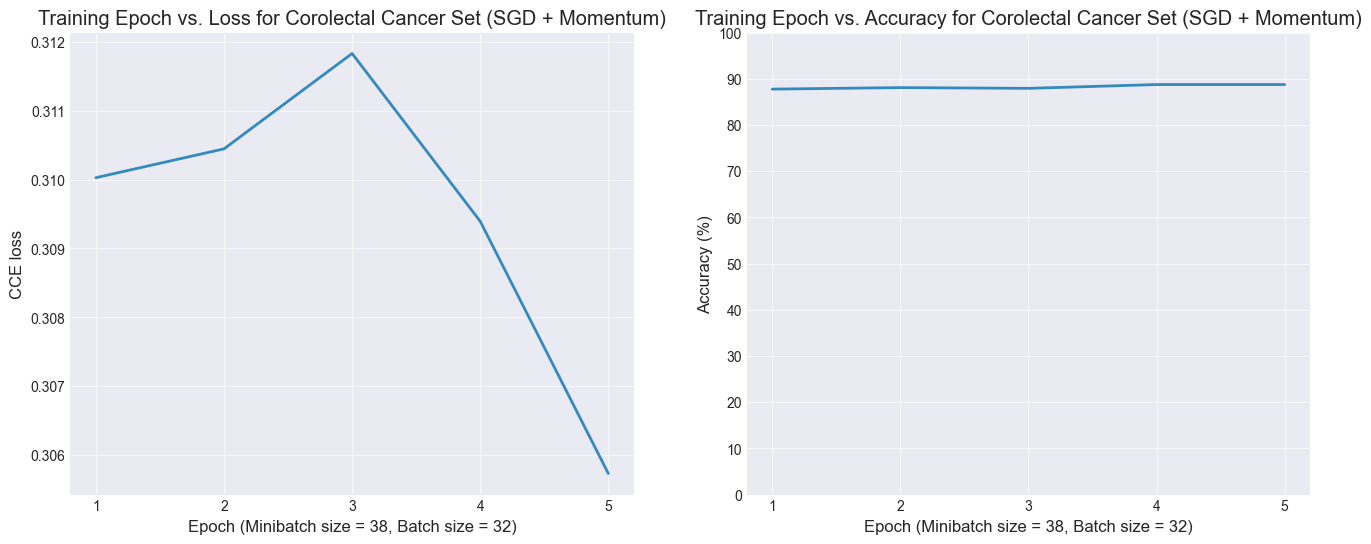

[INFO] Saved the pre-trained model!
[INFO] Finished training w/SGD + Momentum!


In [45]:
# Test set inference
print("[INFO] Begin inference on test set...")

do_model_epoch_loop(resnet_corolectal_cancer_model, test_dataloader, num_epochs, sgd_momentum, _is_training=False, _device=device, _optimizer_name="Momentum")

print("[INFO] Finished training w/SGD + Momentum!")

In [ ]:
# Hyperparameter tuning

#### RMSProp Optimizations

In [ ]:
# Training loop
print("[INFO] Starting training... CHECK")
for epoch in range(num_epochs):  
    resnet_corolectal_cancer_model.train() 
    total_epoch_loss = 0.0  # Track loss for the epoch

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 

        optimizer.zero_grad() 
        
        outputs = resnet_corolectal_cancer_model(inputs)  # Forward pass
        
        loss = nn.CrossEntropyLoss()(outputs, labels)  # Calculate loss
        
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update model parameters using gradients

        total_epoch_loss += loss.item()  

    print(f"[INFO] Epoch {epoch + 1}/{num_epochs}, Loss: {total_epoch_loss / len(train_dataloader):.4f}")

# Evaluation
print("[INFO] Starting evaluation... CHECK")
resnet_corolectal_cancer_model.eval()  
with torch.no_grad(): 
    test_loss = 0.0 
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  
        
        outputs = resnet_corolectal_cancer_model(inputs)  # Forward pass
        loss = nn.CrossEntropyLoss()(outputs, labels)  
        
        test_loss += loss.item()  

    average_test_loss = test_loss / len(test_dataloader)
    print(f"[INFO] Test Loss: {average_test_loss:.4f}, CHECK")